In [1]:
import os 
import xarray as xr
import numpy as np
import glob
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize
import itertools
from numpy.lib.stride_tricks import sliding_window_view
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
import matplotlib.gridspec as gridspec
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from scipy.stats import pearsonr
import utils_results as ut
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
basin = 'NEP'
fitness_model = 'all' # all, linreg, lgbm, pi-lgbm
cluster_type = '_nc' # all, _nc, Anc, DSnc
final_model = 'all' # all, mlp, lgbm, pi-mlp, pi-lgbm
n_clusters_widg = 5 # from 5 to 12, 4 means no number of clusters considered
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'xai-gpi')
results_dir = os.path.join(fs_dir, 'results')
track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
track_df = pd.read_csv(track_file, index_col=0)

In [3]:
# Get the number of features selected for each simulation and the selected variables
atm_vars = ['abs_vo850', 'mpi', 'msl', 'r700', 'sst', 'vo850', 'vws850-200', 'w']
idx_vars = ['EA-WR', 'ENSO3.4', 'EP-NP', 'NAO', 'PDO', 'PNA', 'SOI', 'TNA', 'TSA', 'WP', 'month']
experiments_folders = []
selected_vars_df_list = []
for exp, experiment in enumerate(track_df.iterrows()):
    experiment_folder = experiment[0]
    output_dir = os.path.join(results_dir, basin, experiment_folder)
    n_clusters = experiment[1]['n_clusters']
    model_kind = experiment[1]['model']
    n_vars = ''.join(filter(str.isdigit, experiment[0].split('_')[-2]))
    n_idxs = ''.join(filter(str.isdigit, experiment[0].split('_')[-1]))
    experiment_filename = f'1970-2022_{n_clusters}clusters_{n_vars}vars_{n_idxs}idxs.csv'
    sol_filename = f'{model_kind}_' + experiment_filename
    best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
    best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
    predictor_file = 'predictors_' + experiment_filename
    nc_string = experiment[0].split('_')[2]
    if "A" in nc_string:
        cluster_data = f'{basin}_{n_clusters}clusters_anomaly'
    elif "DS" in nc_string:
        cluster_data = f'{basin}_{n_clusters}clusters_deseason'
    else:
        cluster_data = f'{basin}_{n_clusters}clusters'
    data_dir = os.path.join(fs_dir, 'data', cluster_data)
    predictors_path = os.path.join(data_dir, predictor_file)
    predictors_df = pd.read_csv(predictors_path, index_col=0)
    predictors_df.index = pd.to_datetime(predictors_df.index)
    # Append the experiment folder name to the list and the list of selected variables
    selected_vars_df = ut.df_selected_vars(predictors_df, best_solution)
    selected_vars_df_list.append(selected_vars_df)
    experiments_folders.append(experiment_folder)

In [4]:
# Filter data to consider only the runs with 9 climate indices
track_df = track_df[track_df.index.str.contains('nd9')]
# Filter the data according to the selected fitness model
if fitness_model != 'all':
    track_df = track_df[track_df.index.str.contains(fitness_model)]
# Filter the data according to the selected clustering type
if cluster_type != 'all':
    track_df = track_df[track_df.index.str.contains(cluster_type)]
# If selected a specific number of clusters filter the df according to that number of clusters
if n_clusters_widg != 4 and cluster_type != 'all':
    track_df = track_df[track_df['n_clusters'] == n_clusters_widg]
# Get the top runs according to the selected final model
if final_model != 'all':
    performance_col = f'R_Y_{final_model}'
    sorted_df = track_df.sort_values(performance_col, ascending=False)
    performance_col_noFS = f'R_Y_{final_model}_noFS'
    sorted_df_noFS = track_df.sort_values(performance_col_noFS, ascending=False)
else:
    performance_col = ['R_Y_mlp', 'R_Y_pi-mlp', 'R_Y_lgbm', 'R_Y_pi-lgbm']
    track_df['max_R_Y'] = track_df[performance_col].max(axis=1)
    sorted_df = track_df.sort_values('max_R_Y', ascending=False)
    performance_col_noFS = ['R_Y_mlp_noFS', 'R_Y_pi-mlp_noFS', 'R_Y_lgbm_noFS', 'R_Y_pi-lgbm_noFS']
    track_df['max_R_Y_noFS'] = track_df[performance_col_noFS].max(axis=1)
    sorted_df_noFS = track_df.sort_values('max_R_Y_noFS', ascending=False)

In [5]:
sorted_df

,model,n_clusters,n_features,R_mlp,R_mlp_noFS,R_pi-mlp,R_pi-mlp_noFS,R_lgbm,R_lgbm_noFS,R_pi-lgbm,...,R_S_pi-lgbm_noFS,R_Y_mlp,R_Y_mlp_noFS,R_Y_pi-mlp,R_Y_pi-mlp_noFS,R_Y_lgbm,R_Y_lgbm_noFS,R_Y_pi-lgbm,R_Y_pi-lgbm_noFS,max_R_Y
experiment,,,,,,,,,,,,,,,,,,,,,
test2_pi-lgbm_nc5_nv8_nd9,pi-lgbm,5,16,0.848280,0.832729,0.478895,0.443879,0.841061,0.848365,0.867339,...,0.998184,0.651686,0.191347,-0.316573,-0.517126,0.508767,0.395983,0.649825,0.439382,0.651686
test5_pi-lgbm_nc5_nv8_nd9,pi-lgbm,5,14,0.850389,0.837865,0.383289,0.459219,0.848903,0.848365,0.866709,...,0.998184,0.548674,0.303834,-0.413369,-0.377417,0.537576,0.395983,0.624457,0.439382,0.624457
test3_pi-lgbm_nc5_nv8_nd9,pi-lgbm,5,10,0.855671,0.835219,0.498025,0.452471,0.852981,0.848365,0.866407,...,0.998184,0.554556,0.221814,-0.254404,-0.377984,0.563322,0.395983,0.619904,0.439382,0.619904
test1_pi-lgbm_nc5_nv8_nd9,pi-lgbm,5,13,0.848059,0.840421,0.390000,0.455110,0.850502,0.848365,0.865540,...,0.998184,0.337176,0.248207,-0.280907,-0.401931,0.512461,0.395983,0.600616,0.439382,0.600616
test2_lgbm_nc5_nv8_nd9,lgbm,5,10,0.839567,0.842219,0.461218,0.416460,0.846950,0.848365,0.862497,...,0.998184,0.437252,0.242341,-0.480696,-0.480389,0.491212,0.395983,0.577127,0.439382,0.577127
test5_lgbm_nc5_nv8_nd9,lgbm,5,11,0.844060,0.837639,0.444634,0.449777,0.843085,0.848365,0.865129,...,0.998184,0.396883,0.240173,-0.518382,-0.402670,0.453218,0.395983,0.567392,0.439382,0.567392
test4_linreg_nc5_nv8_nd9,linreg,5,16,0.836659,0.833405,0.452756,0.507353,0.839699,0.848365,0.862490,...,0.998184,0.207776,0.208540,-0.431346,-0.376204,0.478659,0.395983,0.566763,0.439382,0.566763
test4_pi-lgbm_nc5_nv8_nd9,pi-lgbm,5,15,0.818622,0.831718,0.241195,0.497425,0.823329,0.848365,0.847748,...,0.998184,0.187904,0.190806,-0.438067,-0.437699,0.472713,0.395983,0.551982,0.439382,0.551982
test3_linreg_nc5_nv8_nd9,linreg,5,23,0.837758,0.833036,0.445676,0.464071,0.847775,0.848365,0.866378,...,0.998184,0.261408,0.226423,-0.393606,-0.329497,0.418803,0.395983,0.548719,0.439382,0.548719


In [6]:
perc = 80

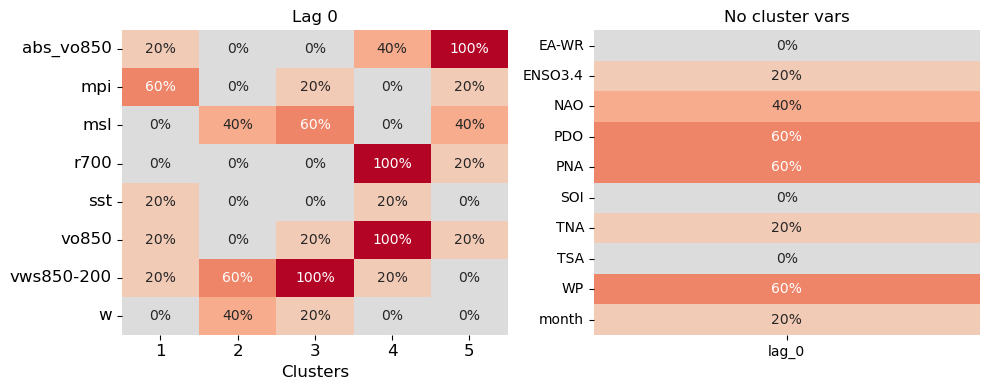

In [7]:
# Best 5 runs
runs = sorted_df.iloc[:5].index.to_numpy()
idxss = np.where(np.isin(experiments_folders, runs))[0]
sel_vars = [selected_vars_df_list[i] for i in idxss]
heatmap, dfx_1 = ut.vars_selection_heatmaps(runs, n_clusters_widg, sel_vars, atm_vars, idx_vars, display_percentage=True, sel_percentage=perc)

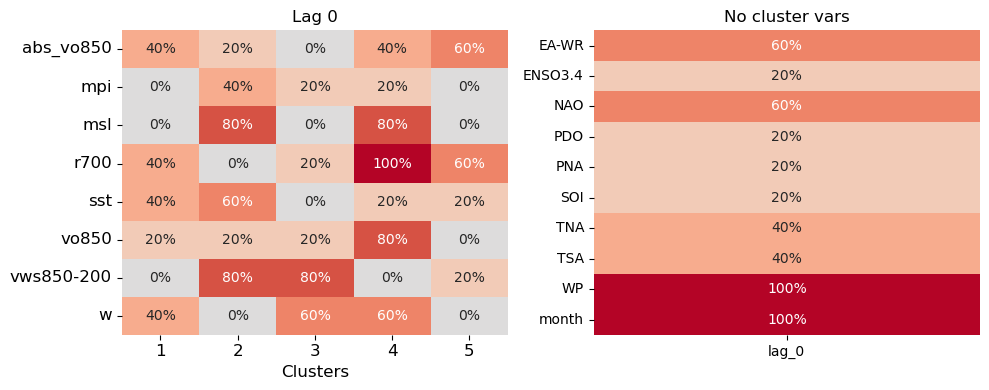

In [8]:
# Run 5-10
runs = sorted_df.iloc[5:10].index.to_numpy()
idxss = np.where(np.isin(experiments_folders, runs))[0]
sel_vars = [selected_vars_df_list[i] for i in idxss]
heatmap, dfx_2 = ut.vars_selection_heatmaps(runs, n_clusters_widg, sel_vars, atm_vars, idx_vars, display_percentage=True, sel_percentage=perc)

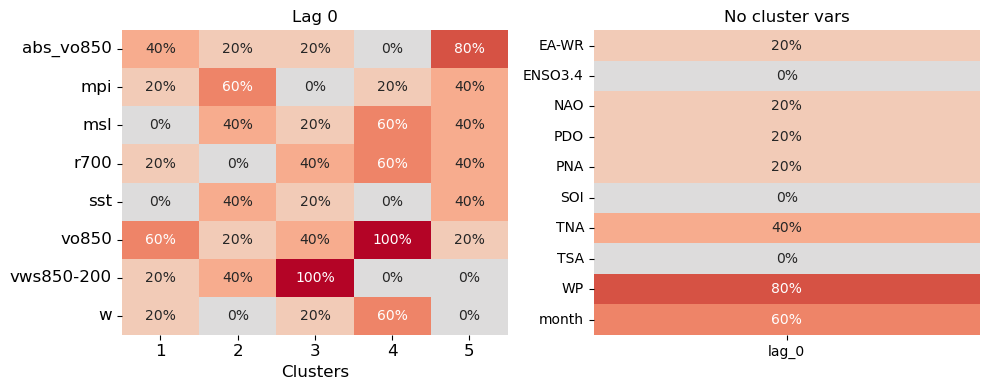

In [9]:
# Run 10-15
runs = sorted_df.iloc[10:].index.to_numpy()
idxss = np.where(np.isin(experiments_folders, runs))[0]
sel_vars = [selected_vars_df_list[i] for i in idxss]
heatmap, dfx_3 = ut.vars_selection_heatmaps(runs, n_clusters_widg, sel_vars, atm_vars, idx_vars, display_percentage=True, sel_percentage=perc)

In [10]:
idxs_vars = np.where(np.isin(dfx_2.selected_vars[0], dfx_1.selected_vars[0]))[0]
var_in_both = [dfx_2.selected_vars[0][i] for i in idxs_vars]
var_only_in_2 = [dfx_2.selected_vars[0][i] for i in range(len(dfx_2.selected_vars[0])) if i not in idxs_vars]
var_only_in_2

['msl_cluster2', 'msl_cluster4', 'vws850-200_cluster2', 'WP', 'month']

In [11]:
idxs_vars = np.where(np.isin(dfx_3.selected_vars[0], dfx_1.selected_vars[0]))[0]
var_in_both = [dfx_3.selected_vars[0][i] for i in idxs_vars]
var_only_in_3 = [dfx_3.selected_vars[0][i] for i in range(len(dfx_3.selected_vars[0])) if i not in idxs_vars]
var_only_in_3

['WP']

In [12]:
idxs_vars = np.where(np.isin(dfx_3.selected_vars[0], dfx_2.selected_vars[0]))[0]
var_in_both = [dfx_3.selected_vars[0][i] for i in idxs_vars]
var_only_in_4 = [dfx_3.selected_vars[0][i] for i in range(len(dfx_3.selected_vars[0])) if i not in idxs_vars]
var_only_in_4

['abs_vo850_cluster5']

No data for NA - DSnc - pi-lgbm - 6


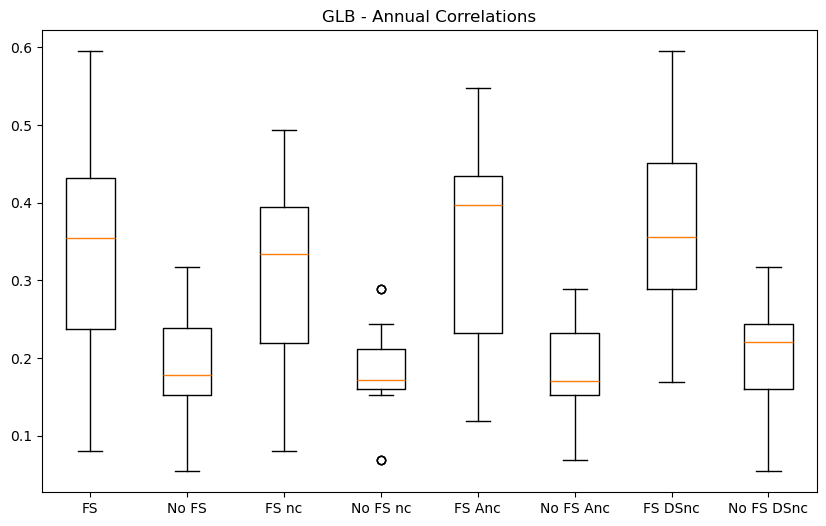

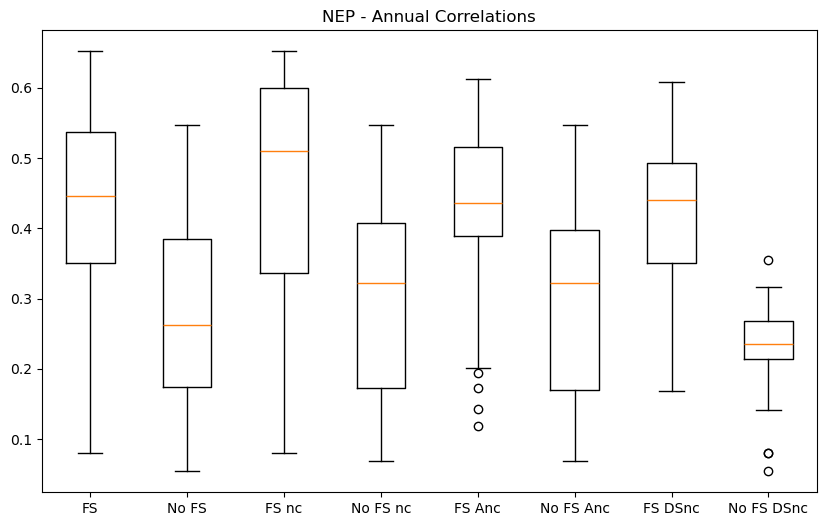

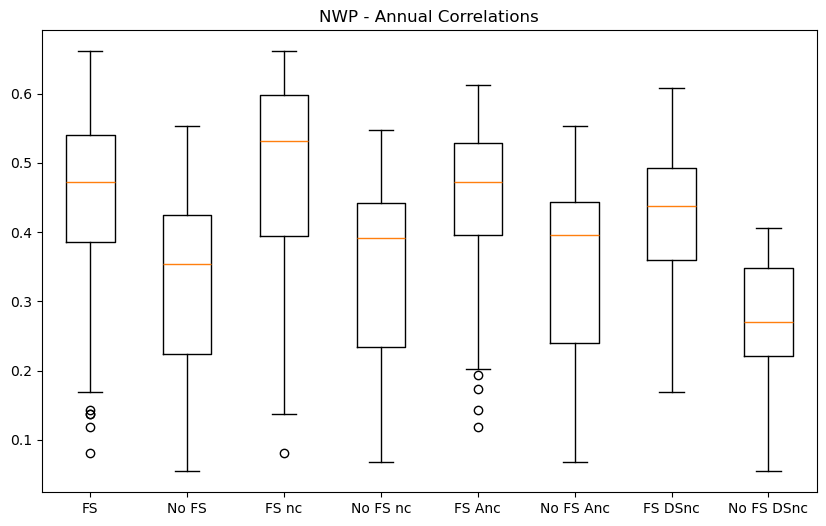

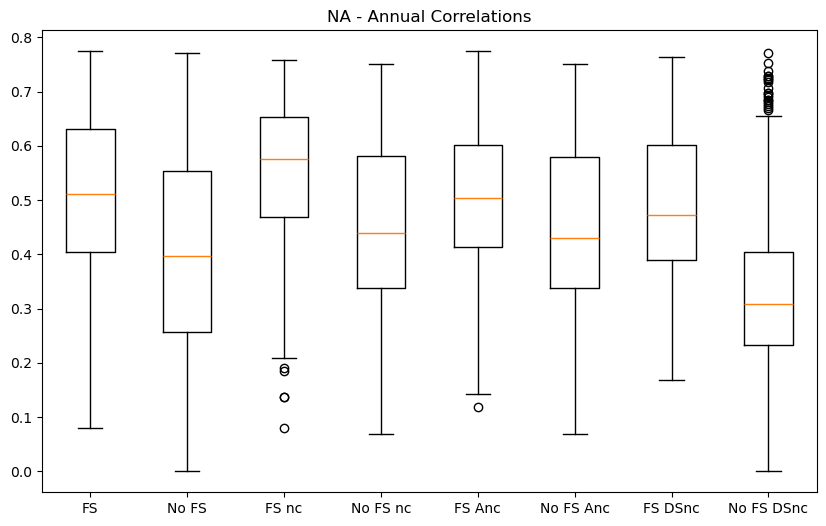

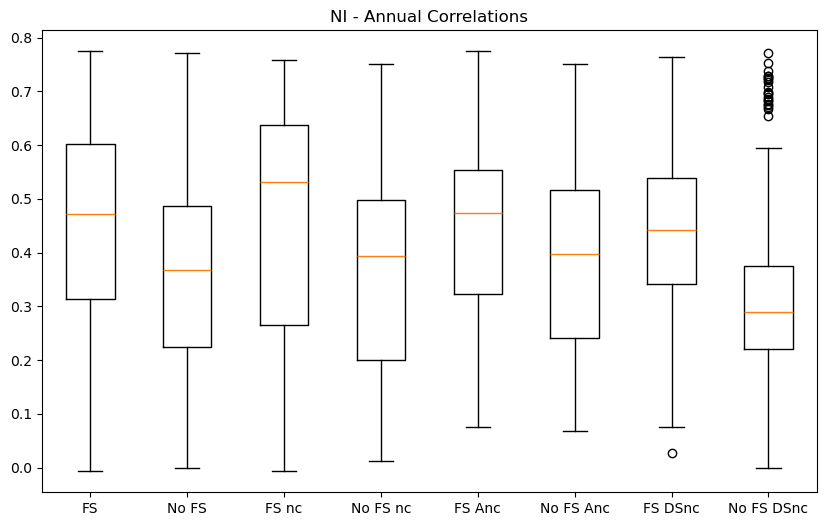

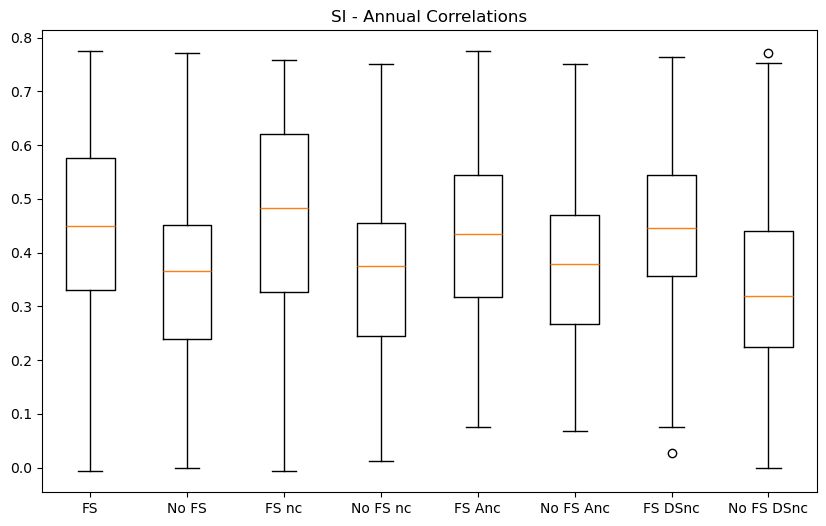

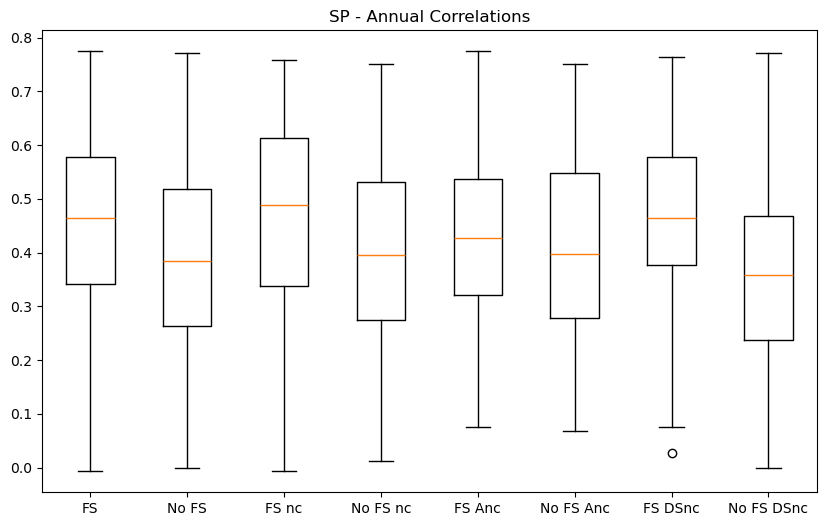

In [13]:
BestRYs = []
BestRYs_noFS = []
BestRYs_nc = [] 
BestRYs_nc_noFS = []
BestRYs_Anc = []
BestRYs_Anc_noFS = []
BestRYs_DSnc = []
BestRYs_DSnc_noFS = []

for basin in ['GLB', 'NEP', 'NWP', 'NA', 'NI', 'SI', 'SP']:
    for cluster_type in ['_nc', 'Anc', 'DSnc']:
        for fitness_model in ['linreg', 'lgbm', 'pi-lgbm']:
            for n_clusters_widg in range(5, 13):
                track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
                track_df = pd.read_csv(track_file, index_col=0)
                track_df = track_df[track_df.index.str.contains('nd9')]
                track_df = track_df[track_df.index.str.contains(fitness_model)]
                track_df = track_df[track_df.index.str.contains(cluster_type)]
                track_df = track_df[track_df['n_clusters'] == n_clusters_widg]
                # Get the top runs according to the selected final model
                if final_model != 'all':
                    performance_col = f'R_Y_{final_model}'
                    sorted_df = track_df.sort_values(performance_col, ascending=False)
                    performance_col_noFS = f'R_Y_{final_model}_noFS'
                    sorted_df_noFS = track_df.sort_values(performance_col_noFS, ascending=False)
                else:
                    performance_col = ['R_Y_mlp', 'R_Y_pi-mlp', 'R_Y_lgbm', 'R_Y_pi-lgbm']
                    track_df['max_R_Y'] = track_df[performance_col].max(axis=1)
                    sorted_df = track_df.sort_values('max_R_Y', ascending=False)
                    performance_col_noFS = ['R_Y_mlp_noFS', 'R_Y_pi-mlp_noFS', 'R_Y_lgbm_noFS', 'R_Y_pi-lgbm_noFS']
                    track_df['max_R_Y_noFS'] = track_df[performance_col_noFS].max(axis=1)
                    sorted_df_noFS = track_df.sort_values('max_R_Y_noFS', ascending=False)
                try:
                    BestR = sorted_df['max_R_Y'].iloc[0]
                    BestR_noFS = sorted_df_noFS['max_R_Y_noFS'].iloc[0]
                except:
                    print(f'No data for {basin} - {cluster_type} - {fitness_model} - {n_clusters_widg}')
                    bestR = 0
                    BestR_noFS = 0

                BestRYs.append(BestR)
                BestRYs_noFS.append(BestR_noFS)
                if cluster_type == '_nc':
                    BestRYs_nc.append(BestR)
                    BestRYs_nc_noFS.append(BestR_noFS)
                elif cluster_type == 'Anc':
                    BestRYs_Anc.append(BestR)
                    BestRYs_Anc_noFS.append(BestR_noFS)
                elif cluster_type == 'DSnc':
                    BestRYs_DSnc.append(BestR)
                    BestRYs_DSnc_noFS.append(BestR_noFS)
    #             # if BestR_noFS > BestR:
    #             #     print(f'{cluster_type} - {fitness_model} - {n_clusters_widg} - {BestR:.3f} - {BestR_noFS:.3f}, noFs better')
    #             # else:
    #             #     print(f'{cluster_type} - {fitness_model} - {n_clusters_widg} - {BestR:.3f} - {BestR_noFS:.3f}')
    plt.figure(figsize=(10, 6))
    plt.boxplot([BestRYs, BestRYs_noFS, BestRYs_nc, BestRYs_nc_noFS, BestRYs_Anc, BestRYs_Anc_noFS, BestRYs_DSnc, BestRYs_DSnc_noFS], 
                labels=['FS', 'No FS', 'FS nc', 'No FS nc', 'FS Anc', 'No FS Anc', 'FS DSnc', 'No FS DSnc'],
                showfliers=True);
    plt.title(f'{basin} - Annual Correlations')

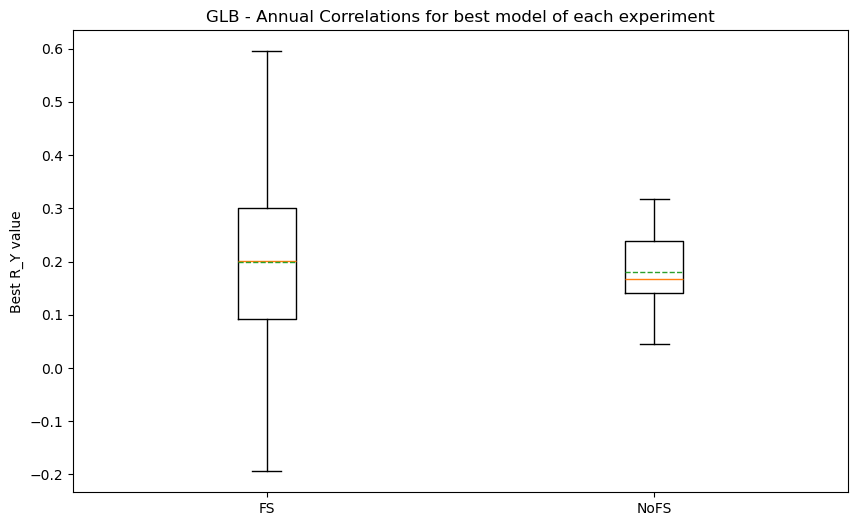

In [16]:
basin = 'GLB'
track_file = os.path.join(results_dir, f'sim_performance_{basin}.csv')
track_df = pd.read_csv(track_file, index_col=0)
track_df = track_df[track_df.index.str.contains('nd9')]
fig, ax = ut.plot_correlation_boxplot(track_df, basin)
ax.set_title(f'{basin} - Annual Correlations for best model of each experiment');